# Clustering Methods for Mixed Data Types


### Notebook by [Marco Tavora](https://marcotavora.me/)

<br>
<img align="left" width="60" height="200" src="https://img.shields.io/badge/R-v3.5.0-green.svg">
<br>


## Table of contents

1. [Introduction](#Introduction)
2. [Data](#Data)

## Introduction
[[go back to the top]](#Table-of-contents)

Using clustering algorithms we can understand how a sample might be comprised of different subgroups. In the present case, the data to be clustered includes both categorical and continuous data and standard distance measures such as Euclidean cannot be used. In the following we will use Gower distances.

## Data
[[go back to the top]](#Table-of-contents)

From [Kaggle](https://www.kaggle.com/c/rossmann-store-sales):
> Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.

### Data dictionary

I will consider only some of the data fields, namely:
- Store - a unique Id for each store
- StoreType - differentiates between 4 different store models: a, b, c, d
- Assortment - describes an assortment level: a = basic, b = extra, c = extended
- CompetitionDistance - distance in meters to the nearest competitor store
- CompetitionOpenSinceMonth - gives the approximate month of the time the nearest competitor was opened

In [48]:
store <- read.csv('store.csv')
store <- store[,c("Store","StoreType","Assortment", "CompetitionDistance", "CompetitionOpenSinceMonth")]
head(store)

Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth
1,c,a,1270,9
2,a,a,570,11
3,a,a,14130,12
4,c,c,620,9
5,a,a,29910,4
6,a,a,310,12


We will use the following packages:
- `dplyr` for data cleaning
- `cluster` for gower similarity and pam
- `Rtsne`  for t-SNE plot
- `ggplot2` for visualization

In [49]:
set.seed(1680) 
library(dplyr) 
library(cluster)
library(Rtsne) 
library(ggplot2) 

## Clustering Analysis of Mixed Types
[[go back to the top]](#Table-of-contents)

From R-bloggers:
> While many introductions to cluster analysis typically review a simple application using continuous variables, clustering data of mixed types (e.g., continuous, ordinal, and nominal) is often of interest. The following is an overview of one approach to clustering data of mixed types using Gower distance, partitioning around medoids, and silhouette width.

### Decisions to make
- Calculate the distances
- Choose the cluster algo
- Selecting the number of clusters

## Gower distance
[[go back to the top]](#Table-of-contents)

- For each variable type there is a particular distance metric that works well for that type. The metric is scaled to fall between 0 and 1. After that, a linear combination with user-specified weights (e.g. averages) is calculated and a final distance matrix is build. The metrics by type [are](https://www.r-bloggers.com/clustering-mixed-data-types-in-r/):

    - quantitative (interval): range-normalized Manhattan distance
    - ordinal: variable is first ranked, then Manhattan distance is used with a special adjustment for ties
    - nominal: variables of k categories are converted into k binary columns and the Dice coefficient is used

- The Gower distance is sensitive to non-normality and outliers of continuous variables. Hence pre-processing is a recommended. 

### Pre-processing to eliminate non-normality

In [50]:
library(gpairs)
library(corrplot)
library(gplots)
library(car)

In [51]:
lambda_CompetitionDistance <- coef(powerTransform(store$CompetitionDistance))
lambda_CompetitionOpenSinceMonth <- coef(powerTransform(store$CompetitionOpenSinceMonth))
lambda_CompetitionDistance
lambda_CompetitionOpenSinceMonth

store$CompetitionDistance 
               0.09898152

store$CompetitionOpenSinceMonth 
                       0.907653

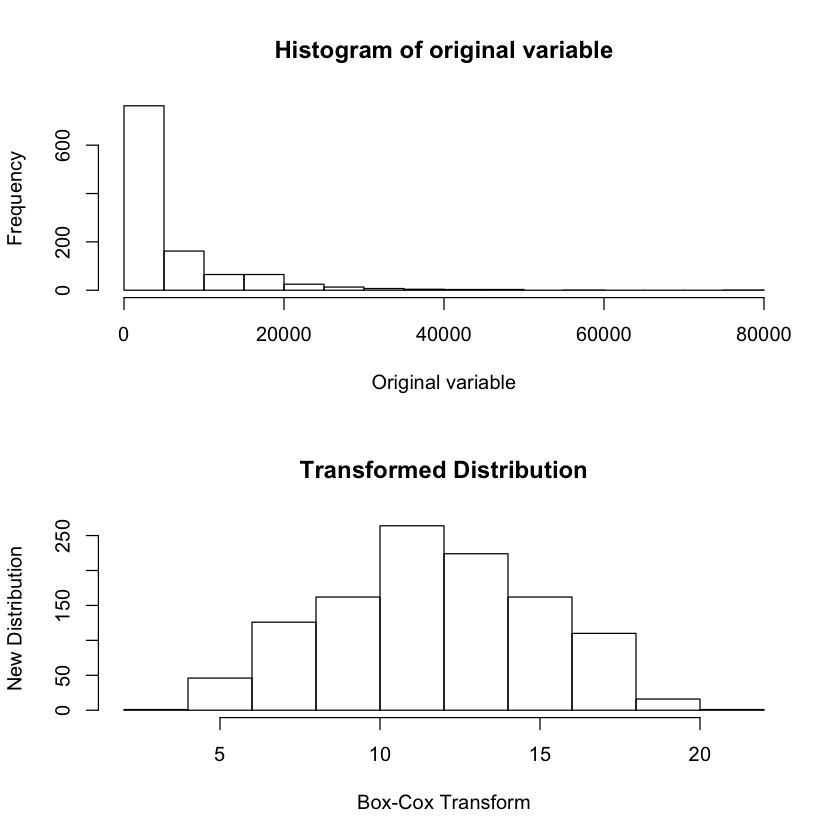

In [52]:
par(mfrow=c(2,1))
hist(store$CompetitionDistance, xlab="Original variable", 
     main="Histogram of original variable")
hist(bcPower(store$CompetitionDistance, lambda_CompetitionDistance),
     xlab="Box-Cox Transform", ylab="New Distribution", 
     main="Transformed Distribution")

In [53]:
store$CompetitionDistance <- bcPower(store$CompetitionDistance, lambda_CompetitionDistance) 

### Drop `NA`

In [54]:
store = na.omit(store)

In [55]:
library(cluster) 

In [56]:
gower.dist <- daisy(store, metric = "gower")

In [57]:
summary(gower.dist)

289180 dissimilarities, summarized :
     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
0.0009001 0.2809200 0.3934200 0.3962600 0.5256600 0.9041400 
Metric :  mixed ;  Types = I, N, N, I, I 
Number of objects : 761

## Choosing a clustering algorithm

We will use partition around medoids (PAM).

In [58]:
sil_width <- c(NA)

for(i in 2:10){
  
  pam_fit <- pam(gower.dist,
                 diss = TRUE,
                 k = i)
  
  sil_width[i] <- pam_fit$silinfo$avg.width
  
}

pam_fit

Medoids:
      ID         
 [1,] "458" "668"
 [2,] "139" "200"
 [3,] "345" "519"
 [4,] "430" "630"
 [5,] "339" "507"
 [6,] "335" "501"
 [7,] "253" "369"
 [8,] "219" "317"
 [9,] "396" "590"
[10,] "559" "813"
Clustering vector:
   1    2    3    4    5    6    7    8    9   10   11   14   15   17   18   20 
   1    2    2    3    4    2    5    2    6    2    6    4    7    2    7    8 
  21   23   24   25   27   28   30   31   33   34   35   36   37   38   39   44 
   3    8    5    1    4    2    4    7    5    1    9    6    1    8    2    2 
  45   46   47   48   49   50   51   52   53   54   55   56   57   58   59   60 
   8    1    5    2    9    8    5    7    6    9    2    7    7    5    6    9 
  61   63   65   67   71   72   73   75   76   77   78   81   82   84   85   86 
   6    3    5    5    2    2    6    9    7    9    2    4    4    6    2    4 
  87   88   89   90   95   96   98   99  102  103  104  106  107  108  109  110 
   2    2    2    2    2    4    9    3    2 

### Plot sihouette width (higher is better)

The number of clusters with highest silhouette width is 6 from the plot below.

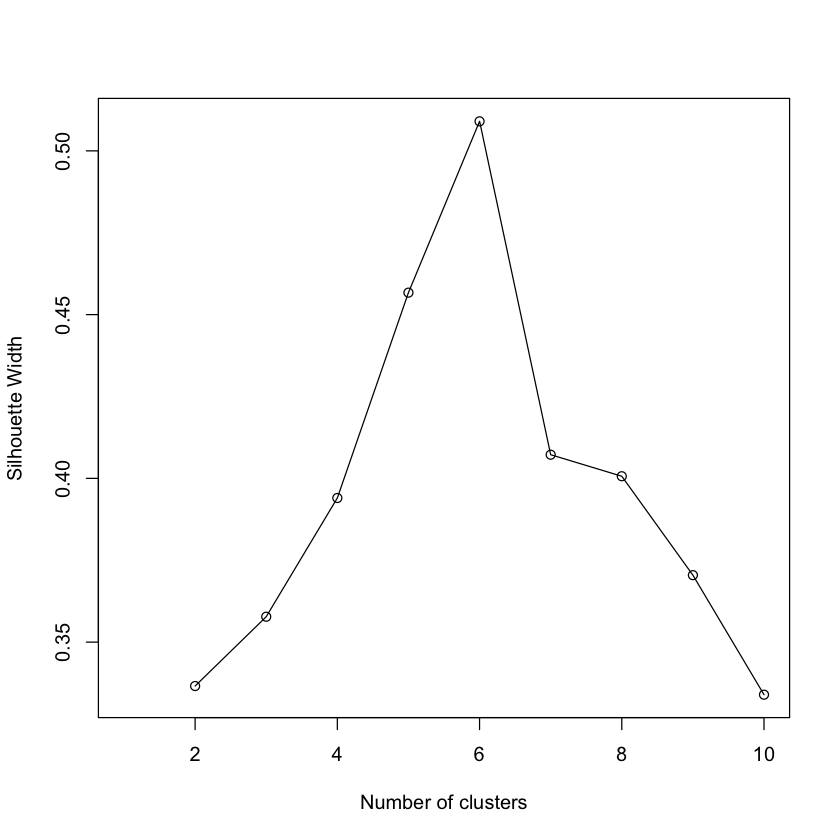

In [59]:
par(mfrow=c(1,1))
plot(1:10, sil_width,
     xlab = "Number of clusters",
     ylab = "Silhouette Width")
lines(1:10, sil_width)

## Interpretation

In [60]:
pam_fit <- pam(gower.dist, diss = TRUE, k = 6)

pam_results <- store %>%
  mutate(cluster = pam_fit$clustering) %>%
  group_by(cluster) %>%
  do(the_summary = summary(.))

pam_results$the_summary

[[1]]
     Store        StoreType Assortment CompetitionDistance
 Min.   :   1.0   a: 0      a:57       Min.   : 4.452     
 1st Qu.: 447.0   b: 3      b: 2       1st Qu.: 8.330     
 Median : 668.0   c:56      c: 0       Median :10.278     
 Mean   : 651.1   d: 0                 Mean   :10.222     
 3rd Qu.: 957.5                        3rd Qu.:12.179     
 Max.   :1109.0                        Max.   :17.050     
 CompetitionOpenSinceMonth    cluster 
 Min.   : 1.000            Min.   :1  
 1st Qu.: 4.000            1st Qu.:1  
 Median : 8.000            Median :1  
 Mean   : 7.169            Mean   :1  
 3rd Qu.: 9.500            3rd Qu.:1  
 Max.   :12.000            Max.   :1  

[[2]]
     Store        StoreType Assortment CompetitionDistance
 Min.   :   2.0   a:295     a:296      Min.   : 4.044     
 1st Qu.: 269.5   b:  1     b:  0      1st Qu.: 8.755     
 Median : 582.0   c:  0     c:  0      Median :10.642     
 Mean   : 554.6   d:  0                Mean   :10.780     
 3rd Q

In [61]:
store[pam_fit$medoids, ]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth
668,668,c,a,10.39291,9
569,569,a,a,10.50205,9
519,519,c,c,11.82267,8
452,452,a,c,11.17044,8
590,590,d,c,13.13715,9
677,677,d,a,11.04175,6


In [62]:
df_clusters <- cbind(store)
df_clusters[pam_fit$medoids, ]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth
668,668,c,a,10.39291,9
569,569,a,a,10.50205,9
519,519,c,c,11.82267,8
452,452,a,c,11.17044,8
590,590,d,c,13.13715,9
677,677,d,a,11.04175,6


In [63]:
df_clusters$cluster <- factor(pam_fit$clustering)

tsne_obj <- Rtsne(gower.dist, is_distance = TRUE, perplexity = 28)

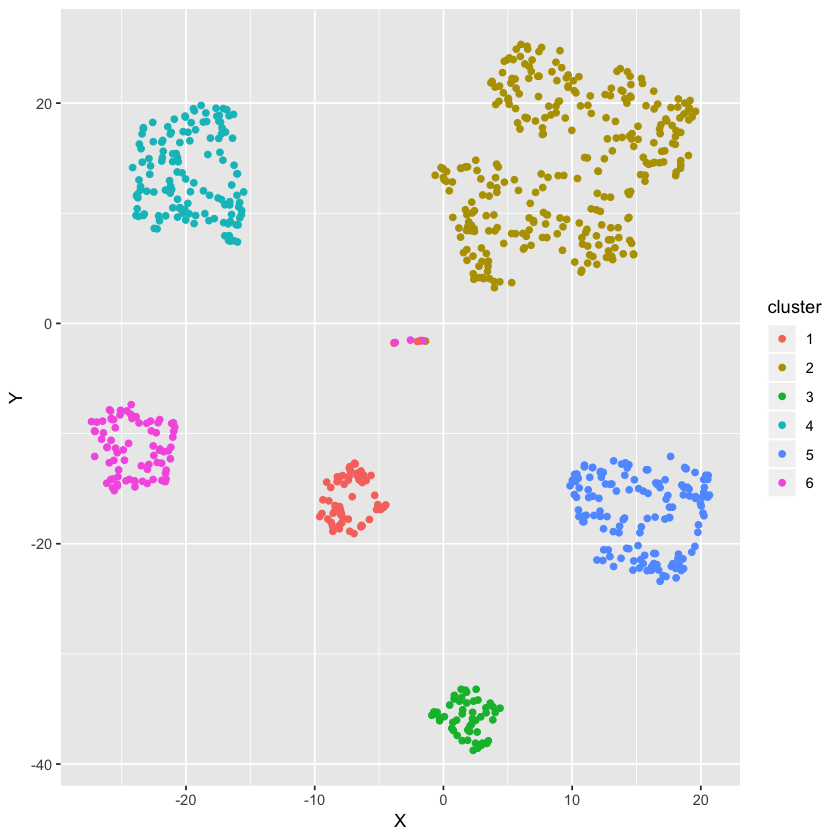

In [64]:
tsne_data <- tsne_obj$Y %>%
  data.frame() %>%
  setNames(c("X", "Y")) %>%
  mutate(cluster = factor(pam_fit$clustering),
         name = store$Store)

ggplot(aes(x = X, y = Y), data = tsne_data) +
  geom_point(aes(color = cluster))

Consider the largest cluster:

In [65]:
data = tsne_data %>% filter(X > 0, Y > 0)

In [66]:
head(data)
dim(data)

X,Y,cluster,name
19.32617,18.74965,2,2
19.03534,15.24453,2,3
10.69588,4.65073,2,5
19.10044,19.57034,2,6
18.43798,14.77562,2,8
17.11165,14.65790,2,10


[1] 290   4

In [68]:
colnames(data) <- c("X", "Y", "cluster", 'Store')
print(data %>% left_join(store, by = "Store") %>% collect %>%.[["Store"]])

  [1]    2    3    5    6    8   10   14   17   27   28   30   39   44   48   55
 [16]   71   72   78   81   82   86   87   88   89   90   95   96  102  104  106
 [31]  107  112  116  117  121  123  124  125  133  134  137  139  142  148  153
 [46]  156  163  164  165  167  170  173  177  181  186  190  191  198  200  204
 [61]  205  219  220  222  235  236  237  240  257  258  260  264  268  270  272
 [76]  276  282  286  290  292  294  295  296  297  303  304  306  307  308  314
 [91]  322  328  329  332  336  341  351  357  358  360  363  374  376  380  381
[106]  391  395  399  400  403  405  407  418  432  434  439  446  451  459  460
[121]  462  475  479  480  489  490  492  502  506  509  511  513  535  537  538
[136]  539  542  544  546  552  558  563  569  570  573  575  581  583  592  594
[151]  597  602  603  606  607  609  610  611  614  619  621  623  625  630  632
[166]  635  639  643  646  649  650  660  665  674  675  679  683  685  686  688
[181]  692  695  698  702  7